# Natural Language Processing 2023-2024 - PyTorch Tutorial
(written by **Ben Eyal**)

Welcome! In this tutorial we will use the SST2 dataset, a standard dataset for the sentiment analysis task.

We will get to know some important PyTorch concepts such as:
* Defining a model: using Embedding, LSTM, and Linear layers and specifying how data flows in the model.
* Writing our own training and evaluation loops.
* Instantiating an optimizer and loss function.
* Making actual predictions!

Have fun! 😁

# Dependencies

In order to make our lives simpler, we will use three third-party dependencies
in addition to PyTorch (which is already installed on Google Colab):

* HuggingFace Datasets (for the SST2 dataset)
* HuggingFace Evaluate (for the evaluation metric)
* HuggingFace Tokenizers (to quickly train a tokenizer)

In [ ]:
!pip install datasets evaluate tokenizers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


# Imports

For this project, we will need:

* PyTorch for building and training the neural network
* 🤗 Datasets, Evaluate, and Tokenizers as explained above
* `tqdm` for a very nice progress bar 😀

In [ ]:
import evaluate # for evaluation metric
import matplotlib.pyplot as plt  # for plotting
import pandas as pd  # only to show some data in a nice table
import torch

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # progress bar

# What is in the Data?

In [ ]:
pd.set_option('display.max_colwidth', None)
dataset = load_dataset("glue", "sst2", split="train")
dataset.set_format(type="pandas", columns=["sentence", "label"])
dataset[:10]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
5,that 's far too tragic to merit such superficial treatment,0
6,"demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .",1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most ` right-thinking ' films,1


# Creating a Tokenizer

Since SST2 already comes kind of pre-tokenized, *i.e.*, the string can be split
on spaces to get valid "words", we don't need to much in the way of a tokenizer.
Here's what we're doing:

1. Load the SST2 training set
2. Create an untrained word-level tokenizer (the most basic kind of tokenizer) and set a specific token to signify "I don't recognize this word", also known as an UNK token.
3. Tell the tokenizer that words are separated by whitespace.
4. Create a trainer for the tokenizer which knows of two special tokens: the pad token (more on that below), and the aforementioned "unknown word" token.
5. Train the tokenizer (takes less than a second).
6. Tell the tokenizer how to pad batches.

🗒**Note**: You can save the tokenizer using `tokenizer.save("tokenizer.json", pretty=True)` and load it later using `Tokenizer.from_file("tokenizer.json")`. You are more than welcome to take a look at the resulting JSON to see exactly which words got which ids.

After this process, we have a tokenizer that does two important things:

* Tokenizes the sentences to individual tokens (in our case, words).
* Gives each word a specific integer identifier which will be the input to our network. For example, "I love sushi." will be converted to `[58, 155, 1, 10]` (the word "sushi" was never seen in the training set, therefore it received the id 1, the UNK token).

## Padding

Since we're working with matrices, all rows must have the same length. That's a problem when dealing with a batch of, let's say, 32 sentences at a time, which can differ in length. If "I love sushi." got us 4 tokens, and "Natural Language Processing is fun!" got us 6 tokens, the first sentence will have to padded with a special token to reach length 6.

In [ ]:
def make_tokenizer():
    dataset = load_dataset("glue", "sst2", split="train")
    tokenizer = Tokenizer(WordLevel(unk_token="<UNK>"))
    tokenizer.pre_tokenizer = WhitespaceSplit()
    trainer = WordLevelTrainer(special_tokens=["<PAD>", "<UNK>"])
    tokenizer.train_from_iterator(dataset["sentence"],
                                  trainer=trainer,
                                  length=len(dataset))
    tokenizer.enable_padding(pad_id=0, pad_token="<PAD>")
    return tokenizer

In [ ]:
tokenizer = make_tokenizer()
tokenizer.save("sst2-tokenizer.json", pretty=True)

# Creating a Sentiment Classifier

We start with a technicality: PyTorch can run on CPU, GPU, and other PUs. To make our code more general, we create a `device` which is `cuda` (GPU) if one is available, and CPU otherwise. We will use this device when instantiating the model and during training/evaluation.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Defining the Model

Since we're talking about using RNNs to classify sentiment (many-to-one task), let's create an RNN model to do just that. Let's go over the two primary (and only) methods in the model: `__init__` and `forward`:

* The `__init__` method is similar to a constructor. It receives the arguments which we will use to instantiate the layers of our network. In our case, we need to know the dimension of the word embeddings, the dimension of the hidden layers of the RNN, how many layers the RNN will have, and whether it will be bidirectional or not.
    * The `nn.Embedding` layer converts the integer token ids to real-valued vectors of a specified size. 50, 100, 300, and 768 are common dimensions to try.
    * The `nn.LSTM` is our RNN of choice. It has to receive `embedding_dim` as input, because that's the output of the previous layer, but the rest is up to us.
    * Finally, we need a fully-connected layer to go from the dimension of the RNN to the specified number of classes (our classes are 0 and 1, so we can just output a single value and sigmoid it later).

* The `forward` method is what happens when we feed an input to the model. It's usually pretty straightforward: take the input `x`, feed it to the first layer, take the output to the next layer, and so on. Two things to notice: `nn.LSTM` returns a tuple: `(output, (h_n, c_n))`, where `(h_n, c_n)` are the hidden and cell states, respectively, as shown in this image:<br>![](https://imgur.com/QPnj3M0.png)<br>
The image below illustrates the relation between the `output` and the `(h_n, c_n)` tuple:
![](https://discuss.pytorch.org/uploads/default/original/2X/e/e7496a33d835f085d800ee17c0ade05895a89551.png)<br>
To make the code easier to work with, we take `output[:, -1]` which means "for all examples in the batch, take only the final hidden state of the final layer". Now all that's left is pass the output to the fully-connected layer and run the sigmoid activation on its output.

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_layers: int,
                 bidirectional=False) -> None:
        super().__init__()
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                                      embedding_dim,
                                      padding_idx=tokenizer.padding["pad_id"])
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,  # by default, the LSTM output is (seq len, batch size, features)
                                               # it is usually more convenient to work with (batch size, seq len, features)
                                               # which is what `batch_first=True` does.
                            bidirectional=bidirectional)
        # if `bidirectional=True` then we concatenate two hidden states,
        # which means we need our fully-connected layer to take twice the hidden size
        self.fc = nn.Linear(2 * hidden_size if bidirectional else hidden_size, 1)

    def forward(self, x) -> torch.Tensor:
        embs = self.embedding(x)
        output, (hidden, cell) = self.lstm(embs)
        return torch.sigmoid(self.fc(output[:, -1]))

## Training and Evaluation Loops

It is no surprise that we need to train our model to get meaningful results. In PyTorch, we need to write the training loop ourselves, but it's pretty much the same always:
1. Put the model in training mode using `model.train()`
2. Zero the accumulated gradients (we rarely want to accumulate gradients between batches)
3. Get the examples and labels from the batch
4. Make a prediction using the model
5. Calculate the loss given the predictions and labels
6. Call `.backward` on the loss to calculate gradients
7. Call `optimizer.step()` to make a gradient descent step

The evaluation loop is pretty much the same, only it doesn't need to calculate gradients and make an optimization step.

If you ever need a reminder, listen to the [Unofficial PyTorch Optimization Loop Song](https://www.youtube.com/watch?v=Nutpusq_AFw)!

In [ ]:
def train(model: SentimentClassifier,
          optimizer: optim.Optimizer,
          loss_fn: nn.BCELoss,
          dataloader: DataLoader,
          metric: evaluate.Metric) -> dict:
    model.train()
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        sentences = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        probs = model(sentences)
        # Two things are happening here:
        # 1. The shape of `probs` is (batch_size, 1).
        #    The `.view(...)` method reshapes the tensor to a specified shape.
        #    Using -1 as a dimension means "PyTorch, please infer the size yourself".
        #    So `probs.view(-1)` converts shape (batch_size, 1) to (batch_size,)
        # 2. loss_fn compares the two input tensors, which have to be of the same type.
        #    We convert the labels, which are in a Long tensor, to a Float tensor.
        loss = loss_fn(probs.view(-1), labels.float())
        loss.backward()
        optimizer.step()
        preds = (probs >= 0.5).int()
        metric.add_batch(predictions=preds, references=labels)
    return metric.compute()


def evaluate_(model: SentimentClassifier,
              dataloader: torch.utils.data.DataLoader,
              metric: evaluate.Metric) -> dict:
    model.eval()
    with torch.inference_mode():  # every operation done in this block will not contribute to gradients
        for batch in tqdm(dataloader, desc="Evaluation"):
            sentences = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            probs = model(sentences)
            preds = (probs >= 0.5).int()
            metric.add_batch(predictions=preds, references=labels)
    return metric.compute()

# The Finale

Let's put everything together:

* We define a batch size
* We load the dataset and encode it to integer ids using our tokenizer from the beginning of the tutorial
* For convenience, we load the metric for SST2, which is accuracy. A `Metric` object has two important methods:
    1. `add_batch` which adds a batch of predictions and labels to the overall computation.
    2. `compute` takes all the predictions and labels that were previously given and simply caluclates accuracy, something like `torch.eq(predictions, labels).float().mean()`.
* We set up DataLoaders, which is how PyTorch gives us batched data
* We instantiate the model, the optimizer, and the loss function
    * Model - Our `SentimentClassifier`.
    * Optimizer - the class constructor takes the model parameters we wish to train (in our case, all of them), and when calling `optimizer.step()` will update them according to the rule specified by the concrete class. For example, `optim.SGD(model.parameters(), lr=0.01)` will create a "vanilla" Stochastic Gradient Descent optimizer with η = 0.1.
    * Loss function - we need a way to know how wrong is the model. PyTorch has many loss functions (sometimes called in PyTorch-land "criterions"). We need specifically the `BCEWithLogitsLoss`. Instantiating a loss class such as `BCEWithLogitsLoss` returns a function with the signature `loss_fn(logits, labels) -> Tensor`. The returned Tensor wraps a single value (the loss), which we can call `loss.backward()` on to calculate gradients ***automagically***.
* Finally, we do several iterations (epochs) on the whole dataset, training and evaluating at each epoch

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Training:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 66.17%
Validation Accuracy: 77.41%


Training:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 88.77%
Validation Accuracy: 78.78%


Training:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 94.20%
Validation Accuracy: 80.96%


Training:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 96.26%
Validation Accuracy: 82.22%


Training:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 97.34%
Validation Accuracy: 83.03%


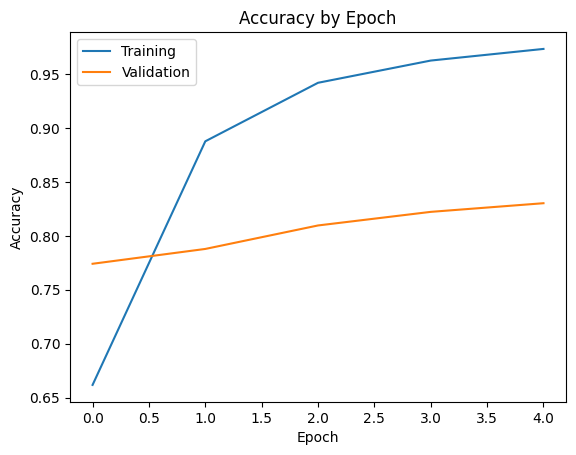

In [ ]:
batch_size = 32

dataset = load_dataset("glue", "sst2")
dataset = dataset.map(lambda ins: {
    "input_ids": [e.ids for e in tokenizer.encode_batch(ins["sentence"])]
}, batched=True, batch_size=batch_size)
dataset.set_format(type="torch", columns=["input_ids", "label"])

metric = evaluate.load("glue", "sst2")

train_dataloader = DataLoader(dataset["train"], batch_size=batch_size)
val_dataloader = DataLoader(dataset["validation"], batch_size=batch_size)

model = SentimentClassifier(embedding_dim=300,
                            hidden_size=128,
                            num_layers=2,
                            bidirectional=True).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

train_accuracies = []
validation_accuracies = []
for epoch in range(5):
    train_metrics = train(model, optimizer, loss_fn, train_dataloader, metric)
    val_metrics = evaluate_(model, val_dataloader, metric)
    train_accuracy = train_metrics['accuracy']
    val_accuracy = val_metrics['accuracy']
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_accuracy:.2f}%")
    print(f"Validation Accuracy: {100 * val_accuracy:.2f}%")
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

# Predict!

Okay, we have a trained model, let's see how it does!

In [ ]:
sentence = "i love learning pytorch"
token_ids = torch.tensor([tokenizer.encode(sentence).ids]).to(device)
pred = model(token_ids).item()
int(pred >= 0.5)

1